# Relatório e código do Trabalho Prático de Análise e Transformação de Dados

Elementos do grupo:
- **Pedro Duarte Santos Henriques 2019217793**<br>
- **Samuel Tiago Almeida Pires 2019225195**


**NOTA: Os Ficheiros de funções presentes no fim do documento devem ser executados em primeiro lugar para uma correta execução do código.**

## 1. Importar Sinais Necessários

Para importar os dados necessários, começamos por criar uma função que lê os ficheiros presentes numa pasta com os DataSets a analisar, e verfica se o formato do nome dos mesmos está de acordo com o necessário

Começaremos a nossa análise por ler os ficheiros das experiencias, fazendo as verificações principais, fazendo as verificações básicas á possibilidade de execução

In [16]:
%Taxa de amostragem dos dados
fs = 50;
if isfile("data.mat")
    load data.mat;
else
    data = lerDados();
    data = lerLabel(data);
    activity_label = lerActivityLabel();
    if(~isa(data,'cell'))
        return
    end
end

## 2. Representar graficamente os sinais importados, identificando a atividade a que cada fragmento corresponde.

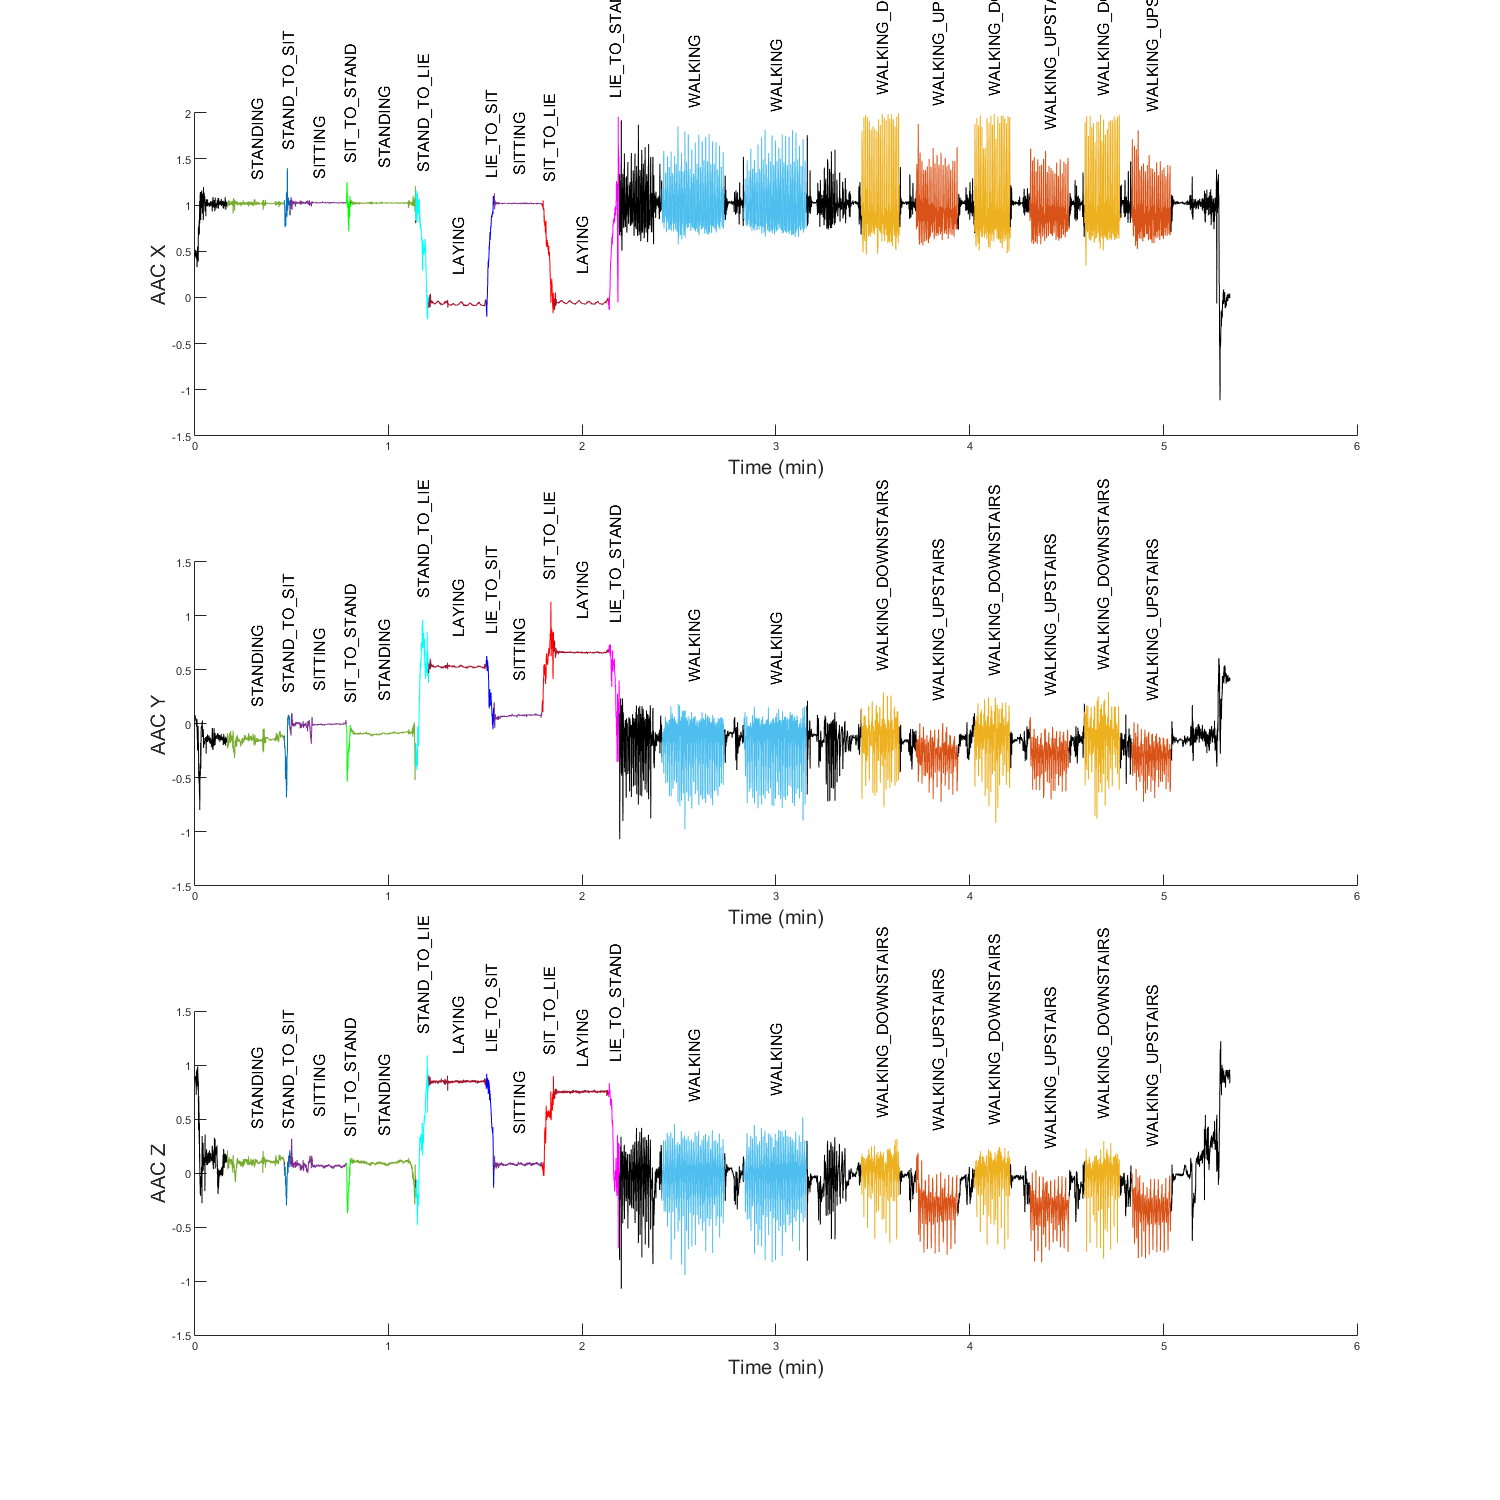

In [17]:
%plot -b inline -w 1500 -h 1500
experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end
[indx,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name', ...
            'Escolha uma experiencia para visualizar');
user_plot(data, activity_label, indx, fs);

## 3. Calcular DFT associado a cada atividade, para todos os utilizadores 

Começamos por calcular as DFT dos dados carregados, aplicando sobre os mesmos várias janelas, de forma a conseguir fazer uma pequena análise sobre o efeito das mesmas.
No entanto, e para efeitos de análise espectral, iremos utilizar a DFT aplicada diretamente aos dados (Janela Retangular).

In [18]:
if ~isfile("data.mat")
    data = DFT(data);
end

## Análise teórica das janelas

### Uma pequena Introdução
Numa primeira fase, isso precisamos de perceber o funcionamento da transformada de Fourier, no nosso caso, em tempo discreto (Devido as limitações computacionais).

Ao aplicar esta transformada pretendemos obter uma **representação em frequencia do sinal original**, para isso, vamos decompomo-lo numa soma cossenos, obtendo assim as frequencias do sinal original, bem como a sua amplitude **num determinado periodo**.

![](Imagens\DFT.png)

*Sendo*:
- *m&Omega;<sub>0</sub> - A frequências angular*
- *C<sub>m</sub> - A Amplitude da frequencia correspondente*
- *&Theta;m - A fase da sinusóide*


### O efeito das janelas

Iniciando a análise de janelas numa perspetiva teórica, sabemos que o sucesso ou não da análise de sinais com uso da transformada DTF pode depender, em grande escala, do tipo de janela a utilizar.
Isto porque as diferenças entre janelas afetam a componente espectral e de resolução em frequencia das janelas.

**Que paramentros analisar?**
- Side Lobe Atenuation: Pretendemos obter o menor Side Lobe possivel, logo uma elevada side lobe atenuation, pois assim conseguimos obter maior energia na frequencia 0 e por isso maior resolução espectral da transformada na frequencia principal, facilitando assim a nossa análise.
- Mainlobe width (-3db): Pretendemos obter o menor mainlobe width possivel, isto porque perdemos resolução espectral quando a largura é mais elevada, o que pode ser prejudicial.
- Spectral leakage: Para entende-lo, temos de relembrar que a transformada DFT considera uma repetição periodica do mesmo sinal e entendendo o que os fenómenos anteriores causam, quando analisamos um sinal não periódico, vazamentos, que normalmente analisamos a partir dos *side lobs* da transformada DFT.<br>Numa representação gráfica deste exemplo podemos utilizar uma função periódica, mas aplicando a DFT a periodo errado.
![](Imagens\Sleakage.png)

- Noise Bandwidth: Este parametro permite-nos analisar, alem dos anteriores, o erro ou ruído causado pela utilização de diferentes janelas, na análise da DFT.


**Vamos apenas realizar uma breve enunciação de cada janela que teorizamos utilizar**
- Janela retangular: A janela retangular, ou seja, a aplicacão da DFT ao espectro de dados sem utilização de nenhuma alteração causa um elevado efeito de *Spectral Leakage*, sendo por isso utilizada como "termo de referencia" para a utilização de outras janelas.
- Janela de Hann: A janela de Hann, a teremos um *Mainlobe width* superior, isto é, menor resolução em frequencia, no entanto ganhamos com a redução do efeito de *Spectral Leakage*.
- Janela de Hamming: A janela de Hamming, surgiu como uma alteração à janela de Hann, tentando reduzir ainda mais os erros de Side Lobe, aumentando a resolução espectral, com uma *Main lobe width* inferior á janela de Hann.
- Janela de Flat Top: Com a Janela flat top, o objetivo é obter uma elevada resolução em frequencia na frequencia 0, mais relevante, a consequencia do sucesso ou não na nossa análise depende das atividades, isto porque, podemos ter atividades com frequencias relevantes fora da frequencia 0, que, com aplicação desta janela ficariam bastante reduzidas.  




---
### Aplicação prática

Neste ponto começamos a análise de dados com aplicação da DFT a todos os fragmento referente a uma atividade, para todos utilizadores.
Para melhorar a nossa análise posterior, guardámos também as larguras de erro dos sinais, para cada largura aplicada, isto porque pretendemos escolher entre quatro janelas, a que achamos ser a mais vantajosa para o projeto em questão, tendo em conta as análises de frequencia, para cada atividade


#### Bibliografia
- [Spectral Leakage and Zero-Padding of the Discrete Fourier Transform](https://dspillustrations.com/pages/posts/misc/spectral-leakage-zero-padding-and-frequency-resolution.html)<br>
- [Windows, Harmonic analysis, and the discrete Fourier transform](https://apps.dtic.mil/dtic/tr/fulltext/u2/a034956.pdf)<br>
- [An Iterative Hybrid Harmonics Detection Method
Based on Discrete Wavelet Transform and
Bartlett–Hann Window](https://www.mdpi.com/2076-3417/10/11/3922/pdf)<br>
- [Multirate FIR Filters for Interpolating and Desampling](https://www.sciencedirect.com/topics/engineering/hamming-window)

### Analise de consequencias de uso de cada uma das janelas

In [20]:
%Mostrar graficos erro das janelas por atividade
mean_size = get_mean_sizes(data);

[act_in,~] = listdlg('ListString', activity_label, 'SelectionMode','single', 'Name','Escolha uma experiencia para visualizar');

mean_activity_size = mean_size(act_in);

temp_window = hamming(mean_activity_size);
hamm = wvtool(temp_window);
hamm.Name = 'Janela de Hamming';
disp(strcat("Mean Hamming Window Noise Bandwith to activity ", activity_label(act_in)));
disp(enbw(temp_window, fs));

temp_window = hann(mean_activity_size);
h = wvtool(temp_window);
h.Name = 'Janela de Hann';
disp(strcat("Mean Hann Window Noise Bandwith to activity ", activity_label(act_in)));
disp(enbw(temp_window, fs));


temp_window = flattopwin(mean_activity_size);
flattop = wvtool(temp_window);
flattop.Name = 'Janela Flatop';
disp(strcat("Mean Flat Top Window Noise Bandwith to activity ", activity_label(act_in)));
disp(enbw(temp_window, fs));


%Make a window viewer with all windows for visual comparision
all_win = wvtool(hamming(mean_activity_size), hann(mean_activity_size), flattopwin( mean_size(act_in)));
all_win.Name = 'Juncão de todas as janelas';

Mean Hamming Window Noise Bandwith to activity SITTING
    0.0787

Mean Hann Window Noise Bandwith to activity SITTING
    0.0866

Mean Flat Top Window Noise Bandwith to activity SITTING
    0.2177




## Análise das janelas, por atividade
Utilizando os valores médios de comprimento, por atividade, decidimos calcular os seguintes valores:

|Tipo de atividade| Atividade      |                               | Hamming     | Hann     | Flat Top |
|:---    | :---     | :---     | :---: | :---:   |:---: |
|**Dinamicas:**|
|                 | Walking        |                               |             |          |          |
|                 |                | Leakege Factor                |      0.04%  | 0.05%    |    0%    |
|                 |                | Relative Side Lobe Atenuation |      42.7 dB|   31.5 dB|  93.6 dB |
|                 |                | Mainlobe width (-3db)         | 0.0026855   | 0.0029297|0.0080566 |
|                 |                | Mean Noise Bandwidth          |    0.0749   | 0.0824   |0.2072    |
|                 |WALKING_UPSTRS  |                              |             |          |          |
|                 |                | Leakege Factor                |      0.04%  | 0.05%    |    0%    |
|                 |                | Relative Side Lobe Atenuation |      42.7 dB|   31.5 dB|  93.6 dB |
|                 |                | Mainlobe width (-3db)         |   0.0041504 |0.0046387 |0.012207  |
|                 |                | Mean Noise Bandwidth          |0.1122       |0.1236    |0.3106    |
|                 | WALKING_DWSTRS |                               |             |          |          |
|                 |                | Leakege Factor                |     0.04%   |   0.05%  | 0%       |
|                 |                | Relative Side Lobe Atenuation |     42.7 dB |  31.5 dB |  93.6 dB |
|                 |                | Mainlobe width (-3db)         |  0.0043945  | 0.0048828| 0.012939 |
|                 |                | Mean Noise Bandwidth          | 0.1199      |   0.1320 |   0.3319 |
|**Estáticas:**   |
|                 | SITTING        |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  93.6 dB |
|                 |                | Mainlobe width (-3db)         |0.0029297    | 0.0031738| 0.0085449|
|                 |                | Mean Noise Bandwidth          |  0.0787     |    0.0866|   0.2177 |
|                 | STANDING       |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  93.6 dB |
|                 |                | Mainlobe width (-3db)         |   0.0024414 | 0.0026855| 0.0073242|
|                 |                | Mean Noise Bandwidth          |     0.0683  |   0.0752 | 0.1891   |
|                 | LAYING         |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  93.6 dB |
|                 |                | Mainlobe width (-3db)         |0.0026855    |0.0029297 |0.0078125 |
|                 |                | Mean Noise Bandwidth          |    0.0727   | 0.0800   | 0.2012   |
|**De transição:**|
|                 | STAND_TO_SIT   |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.6 dB    |  31.5 dB |  91.8 dB |
|                 |                | Mainlobe width (-3db)         |   0.017578  | 0.019531 | 0.050781 |
|                 |                | Mean Noise Bandwidth          |    0.4658   |  0.5137  |   1.2912 |
|                 | SIT_TO_STAND   |                               |             |          |          |
|                 |                | Leakege Factor                |  0.03%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.6 dB    |  31.5 dB |  90.6 dB |
|                 |                | Mainlobe width (-3db)         |    0.023438 |  0.025391|  0.068359|
|                 |                | Mean Noise Bandwidth          |     0.6411  |   0.7075 |    1.7785|
|                 | SIT_TO_LIE     |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  92.5 dB |
|                 |                | Mainlobe width (-3db)         |     0.012695|  0.014648| 0.038086 |
|                 |                | Mean Noise Bandwidth          |      0.3544 |   0.3906 |  0.9819  |
|                 | LIE_TO_SIT     |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.6 dB    |  31.5 dB |  92.1 dB |
|                 |                | Mainlobe width (-3db)         |   0.014648  |  0.016602| 0.043945 |
|                 |                | Mean Noise Bandwidth          |   0.4049    |    0.4464| 1.1221   |
|                 | STAND_TO_LIE   |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  93 dB   |
|                 |                | Mainlobe width (-3db)         |  0.0097656  | 0.01123  |  0.028809|
|                 |                | Mean Noise Bandwidth          |    0.2659   | 0.2930   |   0.7364 |
|                 | LIE_TO_STAND   |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  92.4 dB |
|                 |                | Mainlobe width (-3db)         |   0.013672  |  0.015625| 0.040039 |
|                 |                | Mean Noise Bandwidth          |     0.3698  |  0.4076  |   1.0245 |
|**Valores médios:**|
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  92.4 dB |
|                 |                | Mainlobe width (-3db)         |   0.013672  |  0.015625| 0.040039 |
|                 |                | Mean Noise Bandwidth          |     0.3698  |  0.4076  |   1.0245 |


### Visualização gráfica das janelas DFT
De forma a complementar a nossa análise decidimos implementar um metodo que permita visualizar gráficamente para os nossos dados a influencia que cada janela causa em cada atividade e eixo.

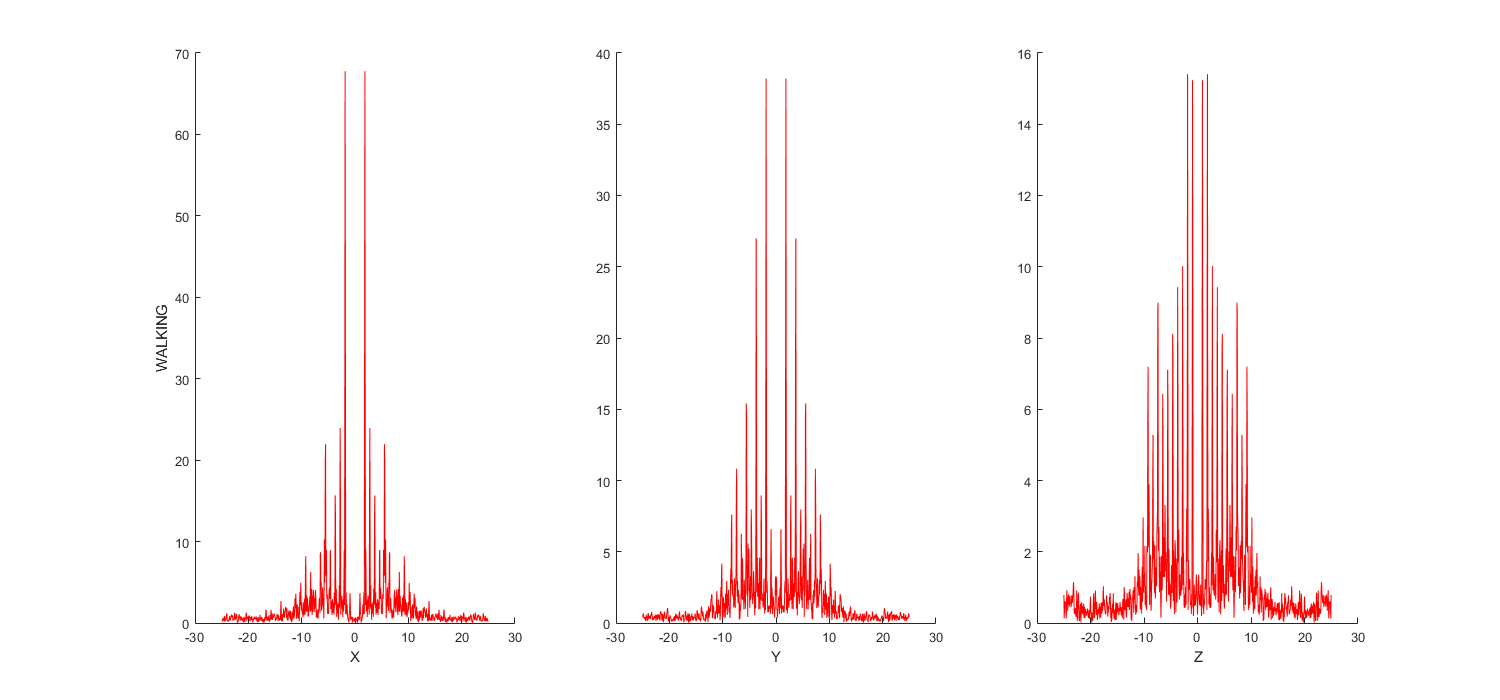

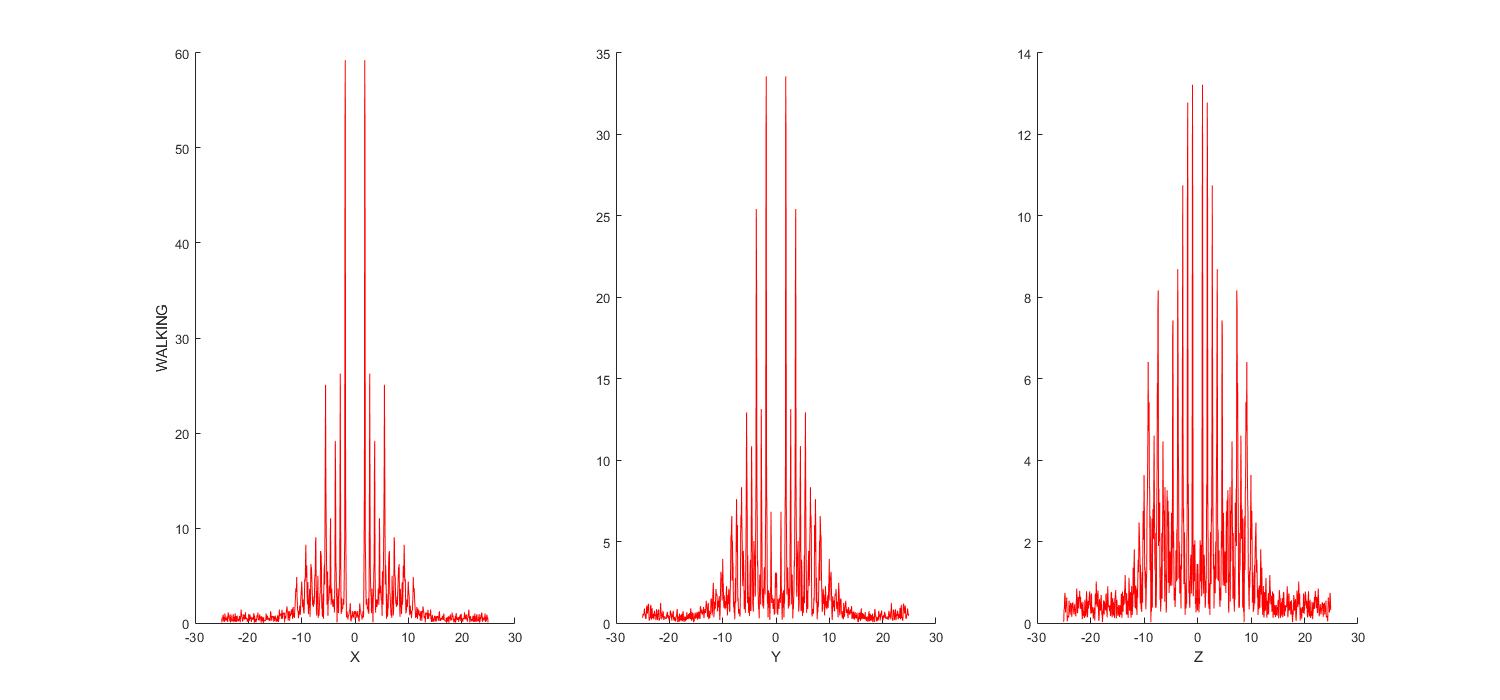

In [20]:
%plot -b inline -w 1500 -h 700
window_names = {'RETANGULAR', 'HAMMING', 'HANN', 'FLAT TOP'};

experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end

%Perguntar dados ao utilizador
[exp_in,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name',...
                            'Escolha uma experiencia para visualizar');
[act_in,~] = listdlg('ListString', activity_label, 'Name','Escolha uma experiencia para visualizar');
[windows,~] = listdlg('ListString', window_names, 'Name','Escolha uma ou mais janelas para visualizar');

DFT_PLOTS(data, exp_in, act_in, fs, activity_label, windows)


### CONCLUSÕES ACERCA DO ESTUDO DAS JANELAS

Acerca das janelas abordadas, chegamos á conclusão não iremos conseguir encontrar uma que seja "perfeita".<br><br>
Da nossa análise, conseguimos ver, por exemplo, o efeito da janela Flat Top, em que obtemos uma elevada resolução na frequencia principal, mas um maior valor em termos de ruido e largura do lóbulo principal, comparativamente á janela de Hann, que apesar de menor resolução na frequencia principal, se apresenta melhor nos restantes parametros.<br><br>
Finalizando, a Janela de Hamming mostrou-se a mais equilibrada das 3 comparadas, logo, será a que iremos utilizar, na aplicação da SFTF (Short-time Fourier Transform).



## Análise espectral dos dados

De forma a realizar a análise espectral dos dados, iremos converter os dados resultantes das nossa DFT em Amplitude, ou seja, converter o resultado da nossa transformada nos coeficientes da Serie de Fourier (C0 + Cm), isto porque, para os varios utilizadores, teremos tamanhos de janelas diferentes e o resultado da DFT varia, mesmo dentro da mesma atividade, consoante o tamanho da janela.

In [21]:
if ~isfile("data.mat")
    data = Dft_to_amp(data);
end

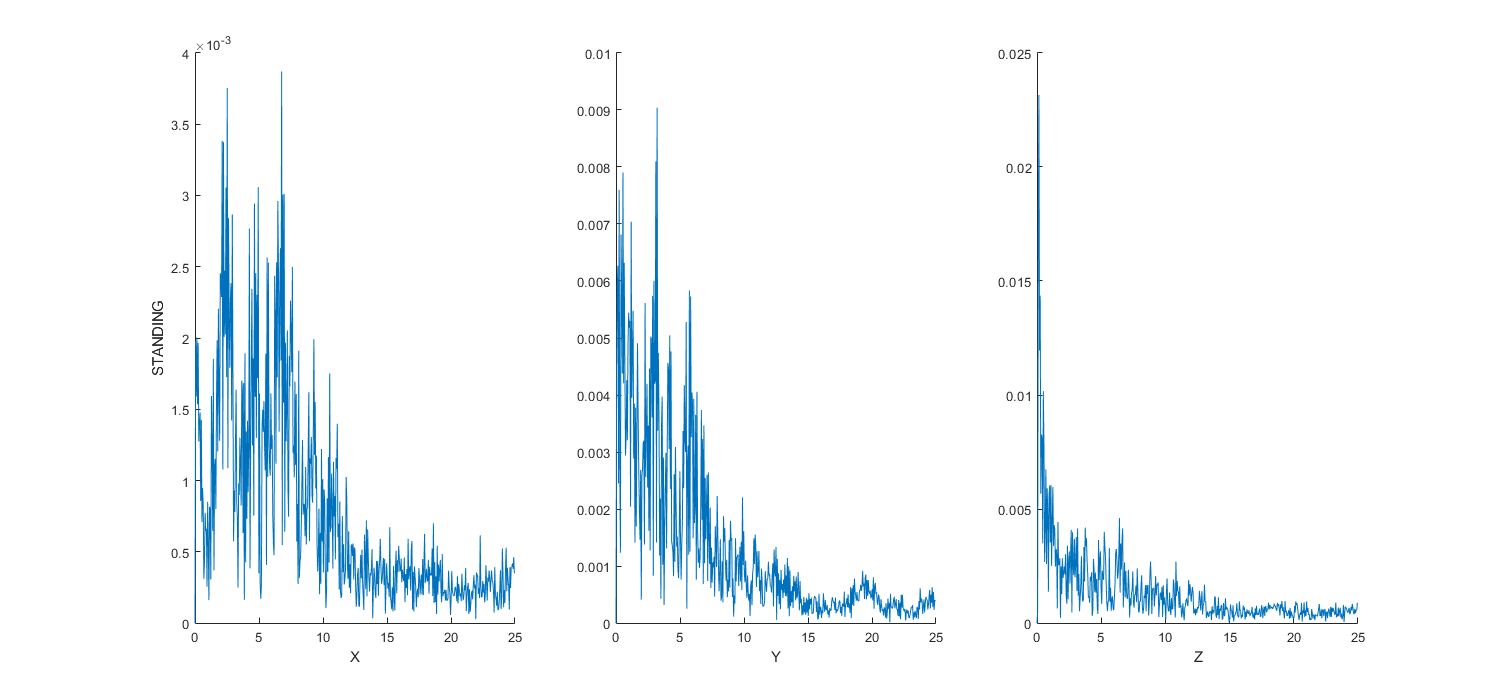

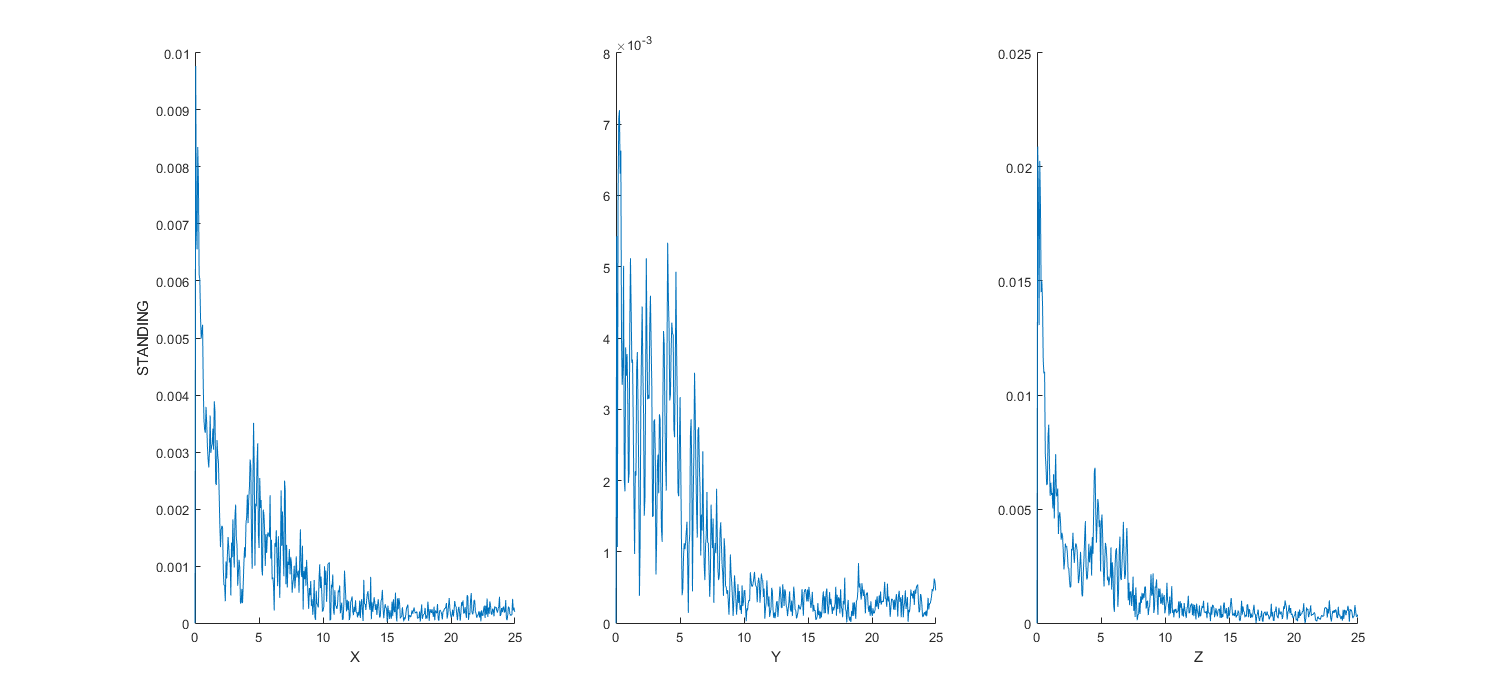

In [27]:
%plot -b inline -w 1500 -h 700
experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end

[exp_in,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name',...
                        'Escolha uma experiencia para visualizar');
[act_in,~] = listdlg('ListString', activity_label, 'Name','Escolha uma experiencia para visualizar');

Ampl_PLOTS(data, exp_in, act_in, fs, activity_label);


## Análise de caracteristicas para cada atividade e utilizador

Depois de transformar a nossa DFT em Paramentro de Amplitude, iremos tentar, numa primeira fase, visualizar os dados por atividade e utilizador e perceber gráficamente alguns parametros que nos permitam ajudar a identificar as principais caracteristicas espectrais, bem como as diferenças as mesmas atividades, tendo utilizadores diferentes.

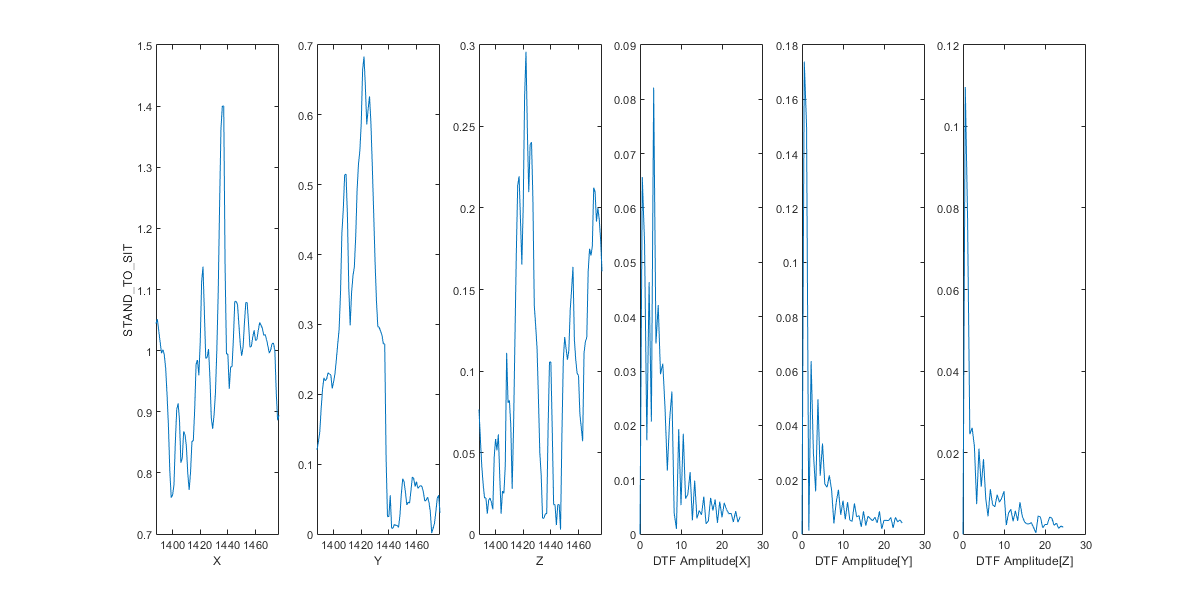

In [22]:
%plot -b inline -w 1200 -h 600
experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end

[exp_in,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name',...
                    "Escolha uma experiencia para visualizar");
[act_in,~] = listdlg('ListString', activity_label, 'Name','Escolha uma experiencia para visualizar');

SPECTRAL_PLOTS(data, exp_in, act_in, fs, activity_label);


Gráficamente conseguimos observar o que já se esperava, devido ás diferenças entre cada pessoa, achamos que as frequencias obtidas variam de utilizador para utilizador, podemos também observar que, até mesmo num individuo, encontram-se diferenças por vezes substanciais de Amplitudes.<br><br>
Para comprovar a nossa teoria decidimos recolher, para cada atividade e utilizador, as frequencias de Amplitude superior a 90%, e as respetivas Amplitudes pois depois de alguns testes, nos pareceu o valor mais indicado para nos apresentar uma estatistica mais realista e estável do valor máximo de Amplitude e frequencia correspondente áquela atividade, para dessa forma fazer uma análise mais estatistica, para alem da visual, das **frequencias e respetivas Amplitudes mais influentes do nosso sinal.**

In [23]:
data = Spectral_relevance(data, fs);

### Análise estatistica por atividade e utilizador

Com os dados obtidos anteriormente, decidimos fazer uma tabela, dividida por utilizador, atividade e eixo com a média e a variância das correspondentes frequencias mais relevantes, para assim conseguirmos obter um valor médio e uma estatistica de erros, e facilitar a observação de possiveis padrões.

In [24]:
% Neste bloco dividimos a frequencias ou Amplitudes mais relevantes, obtidas anteriormente por atividade e utilizador
% Media e variancia por atividade e utilizador em frequencia
act_user_m_freqs = Spectral_user_act_mean(data, 1);

% Media e variancia por atividade e utilizador em Amplitude
act_user_m_Ampl = Spectral_user_act_mean(data, 0);

In [26]:
% Apresenta dados divididos por utilizador, atividade e eixo, numa tabela
disp("Análise de dados em Frequencia:");
user_act_table(act_user_m_freqs, activity_label);
disp("Análise de dados em Amplitude:");
user_act_table(act_user_m_Ampl, activity_label);

Análise de dados em Frequencia:
                                          Tabela de dados e atividade utilizador 5

                          X -> Mean       Variance    Y -> Mean       Variance    Z -> Mean       Variance
                          ________________________    ________________________    ________________________

    WALKING                 1.7671     0.0074331        1.7671     0.0074331        1.0888       0.18644  
    WALKING_UPSTAIRS        1.6549     0.0052949        1.6549     0.0052949       0.81564     0.0035755  
    WALKING_DOWNSTAIRS      1.8047      0.019787        3.1033        1.0712       0.90379      0.010172  
    SITTING                 4.3752        18.504        1.5274        3.7136       0.34106      0.044958  
    STANDING                2.8988        5.5988       0.25224      0.054437       0.29623      0.043114  
    LAYING                 0.72466       0.55463        4.1987         10.52       0.24286      0.025285  
    STAND_TO_SIT           

#### Conclusões acerca da comparação Atividade-Utilizador
Depois de observar a tabela, conseguimos obter algumas conclusões.<br>
Tal como previsto, na generalidade observamos variações entre individuos, no entanto já conseguimos identificar alguns padrões, bem como algumas possiveis dificuldades.<br>
Observamos que, em Amplitude , por exemplo, as atividades estáticas são as que apresentam os menores valores, ou que, se pretendessemos analisar um sinal apenas em frequencia, o eixo z seria o indicado, pois é neste que obtemos os menores valores de variancia.<br>
Verificamos também já algumas diferenças entre as atividades, no entanto, e de forma a obter dados mais exatos sobre as mesmas e assim tirar conclusões mais fidedignas, faremos uma análise mais detalhada sobre cada tipo de atividade.

## Análise por tipo de atividade



De forma a analisar as nossas atividades, em termos de frequencia, decidimos, tal como tinhamos feito para cada utilizador, calcular a média e a variacia das frequencias mais relevantes e respetivas Amplitudes, e apresentar esses gráficos na forma de uma tabela.

In [27]:
act_m_freq = Spectral_act_mean(data, 1);
act_m_Ampl = Spectral_act_mean(data, 0);

In [33]:
disp("Análise de dados em Frequencia:");
act_table(act_m_freq, activity_label);

disp("Análise de dados em Amplitude:");
act_table(act_m_Ampl, activity_label);

Análise de dados em Frequencia:
                          X -> Mean       Variance    Y -> Mean       Variance    Z -> Mean       Variance
                          ________________________    ________________________    ________________________

    WALKING                  1.8029    0.0051105         2.5941      1.9603          1.2841     0.24528   
    WALKING_UPSTAIRS         1.7062     0.012596          1.491     0.13097          1.3242     0.80218   
    WALKING_DOWNSTAIRS       1.8439      0.03127         2.2514      1.2768          1.6185      1.8286   
    SITTING                  3.0783       6.6187        0.80855      1.6789         0.31165    0.083072   
    STANDING                 5.3302       14.094        0.39377     0.37353         0.20554    0.034215   
    LAYING                  0.41777      0.26032         2.8552      8.8965          1.2273      4.3912   
    STAND_TO_SIT             1.3806       1.9934        0.47044    0.012467         0.66627    0.026372   
    

### Conclusão sobre análises de atividades

Em termos de analise sobre atividades, e tal como tinhamos previsto durante a analise sobre cada utilizador, podemos delimitar algumas diferenças entre os tipos de atividades, bem como acerca da distinção dentro do mesmo tipo.

#### Diferenciação entre atividades Dinamicas e as restantes

Podemos observar, de forma muito célere, uma clara diferença no dominio de frequencia entre as atividades Dinâmicas e as restantes, já que obtemos, para todos os eixos, frequencias superiores a 1, o que na generalidade não acontece nas restantes, e quando obtemos, constatamos também valores de variancia elevados, tornando assim estes dados pouco confiáveis. 
Assim, podemos assumir que quando obtivermos frequencias mais elevadas, nos três eixos, será uma atividade dinâmica.

#### Diferenciação dentro do tipo de atividades dinâmica

De forma a análisar e identificar diferenças dentro das atividades, iremos utilizar os valores que nos permitam establecer um padrão, para isso utilizaremos os dados com menor variançia possivel.

Posto isto, establecemos dois possiveis metodos de análise

- A utilização do eixo X com definição em frequencia <br> **Neste caso, o termo de comparação seria:** <br> *WALKING_UPSTAIRS > WALKING > WALKING_DOWNSTAIRS*<br><br>
 
    - Verificámos, consultando a tabela dos utilizadores, uma taxa de acerto de 3 em cada 4 utilizadores, no entanto num dos mesmos os valores de WALKING e WALKING_UPSTAIRS eram bastantes próximos, o que pode provocar uma conclusão errada <br><br>
    
- A utilização de qualquer um dos eixos com definição em Amplitude:
    - Eixo X: <br>**Neste caso, e tomando por base os valores médios o termo de comparação seria:**<br>WALKING > WALKING_UPSTAIRS > WALKING_DOWNSTAIRS<br><br>
        - Tal como a tentativa anterior, esta estrategia demonstrou uma taxa de acerto de 3 em cada 4 utilizadores, no entanto neste caso, os valores mostraram se mais distantes, e por isso mais confiáveis, fica assim como uma hipotese de comparação.<br><br>
        
    - Eixo Y: <br>**Neste caso, e tomando por base os valores médios:**<br>WALKING_DOWNSTAIRS > WALKING > WALKING_UPSTAIRS<br>
         - Tal como a tentativa anterior, esta estrategia demonstrou uma taxa de acerto de 2 em cada 4 utilizadores, sendo assim inferior ás restantes estratégias.<br><br>
         
    - Eixo Z: <br> **Neste caso, e tomando por base os valores médios:**<br>WALKING_DOWNSTAIRS > WALKING > WALKING_UPSTAIRS<br><br>
        - Tal como a tentativa anterior, esta estrategia demonstrou uma taxa de acerto de 1 em cada 4 utilizadores, no entanto, na observação entre utilizadores conseguimos obter a sequencia **WALKING_DOWNSTAIRS > WALKING > WALKING_UPSTAIRS**, que apresenta uma taxa de acerto superior (2 em cada 4), que no entanto se mostra ainda, igual ou inferior ás restantes.<br><br>

Posto isto, concluimos que a melhor forma de indentificar uma atividade Dinâmica seria a partir do Eixo X com definição em Amplitude, pelas razões já enunciadas, e caso possivel, identificar uma forma de utilizar, em conjunto com esta abordagem, os dados também do eixo X com definição em frequência.


#### Diferenciação entre atividades Estaticas e de transição

Uma diferença rapidamente observável entre estes dois tipos de atividades, é a sua duração, que como podemos verificar graficamente, é bastante inferior em atividades estáticas.
No entanto, e utilizando, como esperado, uma análise mais espectral, podemos observar as diferenças de Amplitude, que é bastante inferior caso estejamos a analisar uma atividade estática, em todos os eixos, o que faz sentido, já que numa atividade estática os movimentos a acontecer serão reduzidos, daí também obtermos, neste tipo de atividades, e em definição de frequencia uma elevada variancia, já que, devido á redução de Amplitude dos movimentos, as frequencias a obter serão bastante irregulares.
Podemos também distinguir as atividades de transição pelo efeito, e as diferenças de Amplitude ao longo do tempo, é trivial identificar, nos gráficos, uma diferença substancial de valores durante uma atividade de transição.


#### Tentativa de Diferenciação dentro do tipo de atividades Estatica

De forma a complementar a nossa análise, decidimos tentar diferenciar especificamente cada atividade estática, observamos que o melhor método para isso seria utilizar o Eixo Z em Amplitude, tomando por base a sequencia STANDING > SITTING > LAYING, que demostrou uma taxa de acerto de 3 em cada 4 utilizadores.


#### Tentativa de Diferenciação dentro do tipo de atividades Transição

Já entre os dados de transição, não conseguimos identificar nenhum padrão que consiga diferenciar as atividades, quer em frequencia, quer em Amplitude.
Isto dever-se-á á elevada semelhança entre as atividades deste mesmo tipo *(Exemplo: STAND_TO_SIT <=>  SIT_TO_STAND)*


## Calculo de numero de passos médio por minuto

Para calcular o numero de passos médio por minuto, teremos por base os valores médios de frequencias mais relevantes por atividade e utilizador calculados anteriormente. Sabemos que, a frequencia da amostra sera o numero de vezes que cada eixo será movimentado por segundo, posto isto, numa **atividade dinamica**, esta frequencia será uma **aproximação ao número de passos por segundo**, logo, ao multiplica-la por 60, teremos uma aproximação, para cada utilizador, do número de passos por minuto.


In [28]:
%%file steps_table.m
function steps_table(act_user_m_freqs, activity_label)
    % Esta função deve ser usada para calcular o numero de passos de uma atividade dinamica, por utilizador
    % a partir dos seus dados de frequencias mais relevantes, divididas por atividade
    
steps = cell(length(act_user_m_freqs), 1);
for i = 1:length(act_user_m_freqs)
    for user_activity = 1:3
        for ax = 1:3
            temp_data = cell2mat(act_user_m_freqs{i}.act_mean(user_activity, ax));
            media = mean(temp_data) * 60;
            varian = var(temp_data) * 60;
            steps{i}.user = act_user_m_freqs{i}.user;
            steps{i}.act_mean{user_activity, ax} = [];
            steps{i}.act_mean{user_activity, ax} = [media varian];
        end
    end
end

for i = 1:length(steps)
    user_name = int2str(steps{i}.user);
    disp("                                          Numero médio de passos por atividade e utilizador " + user_name + newline);
    x_name = "X -> Mean       Variance";
    y_name = "Y -> Mean       Variance";
    Z_name = "Z -> Mean       Variance";
    T = cell2table(steps{i}.act_mean, 'VariableNames', [x_name,y_name, Z_name],  'RowNames', activity_label(1:3, 1));
    disp(T);
    disp("" + newline);
end

Created file 'C:\Users\User\Desktop\Projeto ATD\steps_table.m'.


In [29]:
steps_table(act_user_m_freqs, activity_label);

                                          Numero médio de passos por atividade e utilizador 5

                          X -> Mean       Variance    Y -> Mean       Variance    Z -> Mean       Variance
                          ________________________    ________________________    ________________________

    WALKING                  106.03    0.44599           106.03    0.44599            65.33     11.187    
    WALKING_UPSTAIRS         99.295     0.3177           99.295     0.3177           48.938    0.21453    
    WALKING_DOWNSTAIRS       108.28     1.1872            186.2     64.269           54.228    0.61033    



                                          Numero médio de passos por atividade e utilizador 6

                          X -> Mean       Variance    Y -> Mean       Variance    Z -> Mean       Variance
                          ________________________    ________________________    ________________________

    WALKING                 105.38     0.076283         

Posto isto observamos, que depois de uma experiencia prática termos observado que o numero de passos médios de uma pessoa é de 90 a 130 passos por minuto. Por isso, a melhor abordagem para calcular o numero de passos será utilizar o eixo X, utilizando os valores de frequencia para calcular este valores.

## Short-time Fourier Transform

Neste parametro foi-nos pedido que implementassemos uma Short-time Fourier Transform, de forma a simular, por exemplo, o funcionamento de uma aplicação para detetar, em tempo real a atividade a ser realizada por um utilizador.

De forma a aproximarmo-nos o mais possivel do pedido, decidimos, além de apresentar os espectros de frequencia, analisar, ao longo do calculo, os valores de variancia de frequencia e amplitude respetiva, bem como a média desta ultima, de um intervalo de valores definido pelo utilizador, para assim tentar identificar padrões ajudem a identificar, para alem das frequencias,que tipo de atividade estaria a acontecer naquele momento.

No geral, achamos que o resultado foi bom, já que, apesar da nossa análise não ter sido tão profunda como poderia, conseguimos identificar, com alguma exatidão, na grande maioria das experiencias, a partir destes parametros, que tipo de atividade estava a decorrer, no entanto, esta abordagem apresenta ainda alguns defices, pois, ao comparar com os dados originais, verificamos que a identificação não foi 100% precisa e que estamos limitados á identificação do tipo de atividade.



In [44]:
%%file stft.m
function stft(data_z,Fs, dynamic_interval)
    Ts = 1/Fs; % Periodo de amostragem
    N = length(data_z); %Periodo fundamental de x
    
    t = linspace(0, (N-1) * Ts, N);
    s = N*Ts;
    Tframe = 0.005*s;
    %Variaveis tempo
    %Tframe = 2;
    Toverlap = Tframe/2;

    %Relaçao tempo com indices
    Nframe = round(Tframe * Fs);
    Noverlap = round(Toverlap * Fs);

    if mod(Nframe,2) == 0
        f_frame = 0:Fs/Nframe:Fs/2-Fs/Nframe;
    else
        f_frame = 0:Fs/Nframe:Fs/2-Fs/Nframe/2;
    end

    h = hamming(Nframe);
    m_relev = [];
    f_relev = [];
    magn = [];
    nframes = 0;
    tframes = [];
    temp_nframes = 0;
    atividades = [];
    act_t_frames = [];
    espetro_freq = [];
    espetro_magn = [];
    for ii = 1:Nframe-Noverlap:N-Nframe+1
        % aplicar a janela ao sinal do tempo
        x_frame = detrend(data_z(ii:ii+Nframe-1)).*h;

        % obter a magnitude da fft do sinal
        m_X_frame = abs(fftshift(fft(x_frame)));
        
        size_frame = length(m_X_frame);
        mid_index = floor(size_frame/2) + 1;
        m_X_frame = m_X_frame(mid_index:size_frame, 1);
        new_m_X_frame = zeros(size_frame,1);
        %Calcular C0
        new_m_X_frame = m_X_frame(1, 1)/size_frame;
        %Calcular Cm
        if mod(size_frame,2) == 0
            new_m_X_frame(2:mid_index - 1, 1) =  2 .* m_X_frame(2:mid_index - 1, 1)./ size_frame;
        else
            new_m_X_frame(2:mid_index, 1) =  2 .* m_X_frame(2:mid_index, 1)./ size_frame;
        end

        % obter o máximo da magnitude do sinal
        m_X_frame_max = max(new_m_X_frame);
        magn = [magn new_m_X_frame];
        % encontrar os índices do máximo da magnitude do sinal
        ind = find(abs(new_m_X_frame-m_X_frame_max)<0.001);

        % encontrar as frequências correspondentes ao máximo de magnitude
        f_relev = [f_relev, f_frame(ind(1))];
        m_relev = [m_relev, m_X_frame_max];
        nframes = nframes+1;
        temp_nframes = temp_nframes + 1;
        % calcular o vetor de tempo correspondente a cada janela, que aqui
        % corresponde ao valor do vetor de tempos, t, em cada janela
        t_frame = t(ii:ii+Nframe-1);
        tframes = [tframes, t_frame(round(Nframe/2)+1)];
        
        espetro_freq = horzcat(espetro_freq,m_X_frame);
        espetro_magn = horzcat(espetro_magn,new_m_X_frame);
        if(temp_nframes == dynamic_interval)
            m_relev_le = length(m_relev);
            max_ind = find(m_relev(m_relev_le - temp_nframes+1:m_relev_le) > 0.04);
            desvio_padrao_magn = std(m_relev(m_relev_le - temp_nframes+1:m_relev_le));
            desvio_padrao_freq = std(f_relev(m_relev_le - temp_nframes+1:m_relev_le));
            media_magn = mean(m_relev(m_relev_le - temp_nframes+1:m_relev_le));
            if(desvio_padrao_magn >= 0.03 && length(max_ind) <= 3)
                atividades = [atividades "Transição"];
            else
                if(media_magn > 0.03)
                    atividades = [atividades "Dinamica"];
                else
                    atividades = [atividades "Estática"];
                end
            end
            act_t_frames = [act_t_frames t_frame(round(Nframe/2) - dynamic_interval+1)];
            temp_nframes = 0;
        end
    end
    
    imagesc(tframes./60, 1:max(20*log10(espetro_freq)), 20*log10(espetro_freq));
    set(gca,'YDir','normal')
    xlabel("Tempo [min]");
    ylabel("Espectro de Frequencias relevantes");
    for i = 1:length(act_t_frames)
        txt = atividades(i);
        t = text(act_t_frames(i)/60, 5,txt , 'Interpreter' , 'none');
        t.FontSize = 14;
        t.Rotation = 90;  
    end

Created file 'C:\Users\User\Desktop\Projeto ATD\stft.m'.


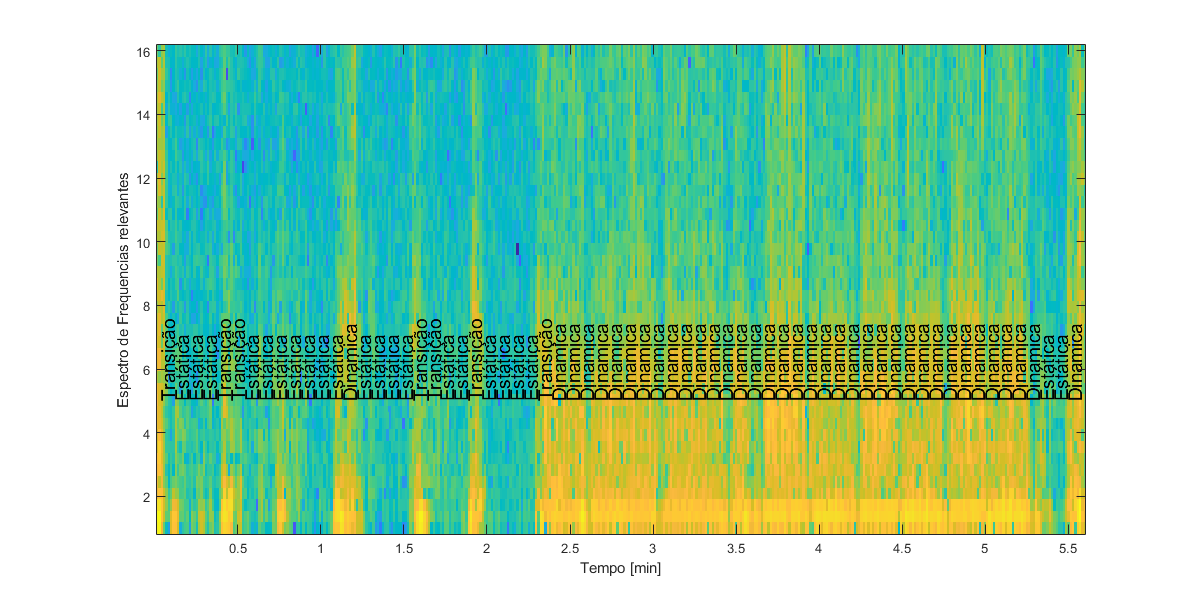

In [46]:
%plot -b inline -w 1200 -h 600
clear all
data = lerDados();
fs = 50;
experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end
dyn_interval = 6;
[exp_in,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name',...
                            'Escolha uma experiencia para visualizar');
data_z = data{exp_in,1}.data(:,3);
stft(data_z, fs, dyn_interval);

## Ficheiros auxiliares
**Estes ficheiros de funções devem ser criados à priori para o correto funcionamento do programa**

##### Funções de Leitura de dados

In [1]:
%%file lerDados.m
function data = lerDados()
PATH = "Data_PL2";
ficheiro_path = dir(PATH);
numero_ficheiros = length(ficheiro_path)-2;
data = cell(numero_ficheiros,1);
string_patern = digitsPattern;

for i = 1:numero_ficheiros
    dados_exp = str2double(extract(ficheiro_path(i+2).name, string_patern));
    if(length(dados_exp) ~= 2)
        warning("Erro a ler conteudo da pasta, verifique a sua pasta e o parsing do ficheiro " + ficheiro_path(i+2).name);
        data = [];
        break
    end
    data{i,1}.data = (load(PATH + '\' + ficheiro_path(i+2).name));
    data{i,1}.user = dados_exp(2); %Guardar utilizador
    data{i,1}.exp_num = dados_exp(1); %Guardar numero experiencia
end

Created file 'C:\Users\User\Desktop\Projeto ATD\lerDados.m'.


In [2]:
%%file lerLabel.m

function data = lerLabel(data)
PATH = "Help\labels.txt";
temp = load(PATH);
%temp = temp(ismember(temp(:, 1),experiencias), :);
for i = 1:length(data)
    exp_labels = temp(:,1) == data{i}.exp_num;
    data{i}.activity.number = num2cell(temp(exp_labels, 3));
    data{i}.activity.start = num2cell(temp(exp_labels, 4));
    data{i}.activity.end = num2cell(temp(exp_labels, 5));
end

Created file 'C:\Users\User\Desktop\Projeto ATD\lerLabel.m'.


In [3]:
%%file lerActivityLabel.m

function label = lerActivityLabel()
PATH = "Help\activity_labels.txt";

temp = table2cell(readtable(PATH));
label = temp(:, 2);

Created file 'C:\Users\User\Desktop\Projeto ATD\lerActivityLabel.m'.


##### Função para representar graficamente os sinais importados, identificando a atividade a que cada fragmento corresponde

In [4]:
%%file user_plot.m
function user_plot(data, activity_label, index, fs)

colors = ['#4DBEEE';'#D95319';'#EDB120';'#7E2F8E';'#77AC30';'#A2142F';'#0072BD';'#00FF00';'#FF0000'; ...
          '#0000FF';'#00FFFF';'#FF00FF'];

figure(1);
indexes = 1:length(data{index}.data);
indexes = indexes./fs./60;

%Adicionar dados no plot(LETRA X)
letter = 88;
for ax = 1:3
    subplot(3,1,ax);
    hold on
    start = 1;
    for i = 1: length(data{index}.activity.number)
        label_begin = cell2mat(data{index}.activity.start(i));
        label_end = cell2mat(data{index}.activity.end(i));
        if label_begin > start
            data_range = start:label_begin;
            data_output = data{index}.data(data_range,ax);
            plot(indexes(data_range),data_output, 'k');
        end
        %obter atividade
        actv_num = cell2mat(data{index}.activity.number(i));
        data_range = label_begin:label_end;
        data_output = data{index}.data(data_range,ax);
        plot(indexes(data_range),data_output, 'color', colors(actv_num,:));
        start = label_end;
        text_pos_y = max(data_output) + 0.2;
        txt = activity_label(actv_num);
        t = text(double(indexes(round((label_begin+label_end)/2))), text_pos_y,txt , 'Interpreter' , 'none');
        t.FontSize = 12;
        t.Rotation = 90;
    end
    data_range = (start:length(data{index}.data(:,ax)));
    data_output = data{index}.data(data_range,ax);
    plot(indexes(data_range), data_output, 'k');
    xlabel("Time (min)", 'FontSize' , 15);
    ylabel(strcat("AAC ", char(letter)), 'FontSize' , 15);
    letter = letter + 1;
    hold off
end

Created file 'C:\Users\User\Desktop\Projeto ATD\user_plot.m'.


##### Calculo das DFTS associadas aos dados de cada experiencia para diferentes janelas

In [5]:
%%file DFT.m
function data = DFT(data)
for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.number);
    for user_activity = 1:n_act_users
        
        start_index = cell2mat(data{experience}.activity.start(user_activity,1));
        end_index = cell2mat(data{experience}.activity.end(user_activity,1));
        data_range = start_index:end_index;
        data_s = length(data_range);
        for ax = 1:3
            %DFT Janela Retangular
            data_to_DFT = detrend(data{experience}.data(data_range, ax));
            data{experience}.activity.DFT_RECT{user_activity, ax} =  fftshift(fft(data_to_DFT));

            %DFT Janela Hamming
            window = hamming(data_s);
            data_to_DFT = detrend(data{experience}.data(data_range, ax)) .* window;
            data{experience}.activity.DFT_HAMMING{user_activity, ax} =  fftshift(fft(data_to_DFT));
         
            %DFT Janela Hann
            window = hann(data_s);
            data_to_DFT = detrend(data{experience}.data(data_range, ax)) .* window;
            data{experience}.activity.DFT_HANN{user_activity, ax} =  fftshift(fft(data_to_DFT));

            %DFT Janela Flat top
            window = flattopwin(data_s);
            data_to_DFT = detrend(data{experience}.data(data_range, ax)) .* window;
            data{experience}.activity.DFT_FLATOP{user_activity, ax} =  fftshift(fft(data_to_DFT));
        end
    end
end

Created file 'C:\Users\User\Desktop\Projeto ATD\DFT.m'.


##### Função para obter valores médios de comprimentos de janelas, por atividade, para análise dos diferentes tipo de janela

In [6]:
%%file get_mean_sizes.m
function mean_size = get_mean_sizes(data)
    exp_indexes = 1:length(data);
    mean_size = zeros(12, 1);
    for i = 1:12
        n_am = 0;
        n_sum = 0;
        for experience = exp_indexes
            indexes = find(i == cell2mat(data{experience}.activity.number));
            len = cell2mat(data{experience}.activity.end(indexes)) - cell2mat(data{experience}.activity.start(indexes));
            n_sum = n_sum + sum(len);
            n_am = n_am + length(len);
        end
        mean_size(i) = round(n_sum / n_am);
    end
end

Created file 'C:\Users\User\Desktop\Projeto ATD\get_mean_sizes.m'.


##### Função para representar gráficamente a DFT, de forma a analisar também os efeitos dos diferentes tipos de janela

In [7]:
%%file DFT_PLOTS.m
function DFT_PLOTS(data, experience,act_in, Fs, activity_label, windows)
colors = ['#00FF00';'#FF0000';'#0000FF';'#00FFFF';'#FF00FF'];

data_act_index = [];
for i = 1:length(act_in)
    indexes = find(cell2mat(data{experience}.activity.number) == act_in(i))';
    data_act_index = [data_act_index indexes];
end


for user_activity_index = 1:length(data_act_index)
   figure
   index = 0;
   user_activity = data_act_index(user_activity_index);
   start_index = cell2mat(data{experience}.activity.start(user_activity,1));
   end_index = cell2mat(data{experience}.activity.end(user_activity,1));
   data_range = start_index:end_index;
   N = length(data_range);
   if mod(N,2) == 0
            f = -Fs/2:Fs/N:Fs/2-Fs/N;
   else
            f = -Fs/2 + Fs/N/2:Fs/N:Fs/2-Fs/N/2;
   end


   actv_num = cell2mat(data{experience}.activity.number(user_activity));
   ylabel(activity_label(actv_num));
   
   for ax = 1:3
        color = 1;
        subplot(1, 3, index + ax);
        hold on
        if ismember(1, windows)
            DFT_RECT = data{experience}.activity.DFT_RECT{user_activity, ax};
            plot(f, abs(DFT_RECT), '-', 'color', colors(color, :));
        end
        color = color + 1;
        if ismember(2, windows)
            DFT_HANN = data{experience}.activity.DFT_HANN{user_activity, ax};
            plot(f, abs(DFT_HANN), '-', 'color', colors(color, :));
        end
        color = color + 1;
        if ismember(3, windows)
            DFT_HAMMING = data{experience}.activity.DFT_HAMMING{user_activity, ax};
            plot(f, abs(DFT_HAMMING), '-', 'color', colors(color, :));
        end
        color = color + 1;
        if ismember(4, windows)
            DFT_FLATOP = data{experience}.activity.DFT_FLATOP{user_activity, ax};
            plot(f, abs(DFT_FLATOP), '-', 'color', colors(color, :));
        end
        if ax == 1
            xlabel("X");
            ylabel(activity_label(actv_num), 'Interpreter' , 'none');
        elseif ax == 2
            xlabel("Y");
        else
            xlabel("Z");
        end
   end
   
   index = index + 3;
end

Created file 'C:\Users\User\Desktop\Projeto ATD\DFT_PLOTS.m'.


##### Função para transformar dados da DFT em Amplitude

In [8]:
%%file Dft_to_amp.m
function data = Dft_to_Ampl(data)
for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.number);
    for user_activity = 1:n_act_users
        for ax = 1:3
            dft_abs = abs(data{experience}.activity.DFT_RECT{user_activity, ax});
            
            N = length(dft_abs);
            mid_index = floor(N/2) + 1;
            dft_abs = dft_abs(mid_index:N, 1);
            data{experience}.activity.Ampl{user_activity, ax} = zeros(length(dft_abs),1);
            %Calcular C0
            data{experience}.activity.Ampl{user_activity, ax}(1,1) = dft_abs(1, 1)/N;
            %Calcular Cm
            if mod(N,2) == 0
                data{experience}.activity.Ampl{user_activity, ax}(2:mid_index - 1,1) =  2 .* dft_abs(2:mid_index - 1, 1)./ N;
            else
                data{experience}.activity.Ampl{user_activity, ax}(2:mid_index,1) =  2 .* dft_abs(2:mid_index, 1)./ N;
            end
              
        end
    end
end

Created file 'C:\Users\User\Desktop\Projeto ATD\Dft_to_amp.m'.


##### Função para representar graficamente a Amplitude de uma dada atividade, numa experiencia

In [9]:
%%file Ampl_PLOTS.m
function Ampl_PLOTS(data, experience, act_in, Fs, activity_label)

data_act_index = [];
for i = 1:length(act_in)
    indexes = find(cell2mat(data{experience}.activity.number) == act_in(i))';
    data_act_index = [data_act_index indexes];
end


for user_activity_index = 1:length(data_act_index)
   figure
   index = 0;
   user_activity = data_act_index(user_activity_index);
   start_index = cell2mat(data{experience}.activity.start(user_activity,1));
   end_index = cell2mat(data{experience}.activity.end(user_activity,1));
   data_range = start_index:end_index;
   N = length(data_range);
   if mod(N,2) == 0
            f = 0:Fs/N:Fs/2-Fs/N;
   else
            f = 0:Fs/N:Fs/2-Fs/N/2;
   end
   actv_num = cell2mat(data{experience}.activity.number(user_activity));
   for ax = 1:3
        subplot(1, 3, index + ax);
        hold on
        Ampli = data{experience}.activity.Ampl{user_activity, ax};
        plot(f, abs(Ampli), '-'); 
        if ax == 1
            xlabel("X");
            ylabel(activity_label(actv_num), 'Interpreter' , 'none');
        elseif ax == 2
            xlabel("Y");
        else
            xlabel("Z");
        end
   end
   index = index + 3;
end

Created file 'C:\Users\User\Desktop\Projeto ATD\Ampl_PLOTS.m'.


##### Funcão auxiliar para comparar graficamente os dados em "RAW" da atividade com a sua representação em Amplitude

In [10]:
%%file SPECTRAL_PLOTS.m

function SPECTRAL_PLOTS(data, experience, act_in, Fs, activity_label)

data_act_index = [];
for i = 1:length(act_in)
    indexes = find(cell2mat(data{experience}.activity.number) == act_in(i))';
    data_act_index = [data_act_index indexes];
end
for user_activity_index = 1:length(data_act_index)
   figure
   index = 0;
   user_activity = data_act_index(user_activity_index);
   start_index = cell2mat(data{experience}.activity.start(user_activity,1));
   end_index = cell2mat(data{experience}.activity.end(user_activity,1));
   
   data_range = start_index:end_index;
   N = length(data_range);
   
   if mod(N,2) == 0
            f = 0:Fs/N:Fs/2-Fs/N;
   else
            f = 0:Fs/N:Fs/2-Fs/N/2;
   end
   
   actv_num = cell2mat(data{experience}.activity.number(user_activity));
   for ax = 1:3
        %Plot data
        subplot(1, 6, index + ax);
        data_to_plot = data{experience}.data(data_range, ax);
        plot(data_range, abs(data_to_plot), '-'); 
        if ax == 1
            xlabel("X");
            ylabel(activity_label(actv_num), 'Interpreter' , 'none');
        elseif ax == 2
            xlabel("Y");
        else
            xlabel("Z");
        end
        
        % Plot Amplitude em frequencia
        subplot(1, 6, 3 + index + ax);
        data_to_plot = data{experience}.activity.Ampl{user_activity, ax};
        plot(f, abs(data_to_plot), '-'); 
        
        if ax == 1
            xlabel("DTF Amplitude[X]");
        elseif ax == 2
            xlabel("DTF Amplitude[Y]");
        else
            xlabel("DTF Amplitude[Z]");
        end
        
   end
   index = index + 3;
end

Created file 'C:\Users\User\Desktop\Projeto ATD\SPECTRAL_PLOTS.m'.


#### Função para calcular frequencias mais relevantes e respetivas Amplitudes 

In [11]:
%%file Spectral_relevance.m
function data = Spectral_relevance(data, Fs)
for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.Ampl);
    for user_activity = 1:n_act_users
        N = length(data{experience}.activity.DFT_RECT{user_activity, 1});
        if mod(N,2) == 0
                f = 0:Fs/N:Fs/2-Fs/N;
        else
                f = 0:Fs/N:Fs/2-Fs/N/2;
        end
        for ax = 1:3
            Ampl = cell2mat(data{experience}.activity.Ampl(user_activity, ax));
            %Definir relevancia das frequencias
            min_Ampl = 0.90 * max(abs(Ampl));
            [~, locs] = findpeaks(abs(Ampl), 'MinPeakHeight', min_Ampl);
            data{experience}.activity.fRelevant{user_activity, ax} = f(locs)';
            data{experience}.activity.AmplRelevant{user_activity, ax} = Ampl(locs);
        end
    end
end

Created file 'C:\Users\User\Desktop\Projeto ATD\Spectral_relevance.m'.


##### Função para realizar a media e variancia, em frequencias ou em Amplitudes mais relevantes, conforme pedido pelo utilizador, dividida por utilizador e atividade

In [12]:
%%file Spectral_user_act_mean.m
function act_user_m = Spectral_user_act_mean(data, infreq)
n_user = 0;
users_array = [];
for experience = 1:length(data)
    user = data{experience}.user;
    if ~ismember(user, users_array)
        users_array = [users_array user];
        n_user = n_user + 1;
    end
end

act_user_m = cell(n_user , 1);
for i = 1:n_user
    act_user_m{i}.user = users_array(i);
    act_user_m{i}.act_mean = cell(12,3);
end

for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.Ampl);
    user = data{experience}.user;
    user_index = find(users_array == user);
    for user_activity = 1:n_act_users        
        act_num = cell2mat(data{experience}.activity.number(user_activity));
        for ax = 1:3
            if(infreq == 1)
                data_in = cell2mat(data{experience}.activity.fRelevant(user_activity, ax));
            else
                data_in = cell2mat(data{experience}.activity.AmplRelevant(user_activity, ax));
            end
            temp_data = cell2mat(act_user_m{user_index}.act_mean(act_num, ax));
            new = [temp_data data_in'];
            act_user_m{user_index}.act_mean{act_num, ax} = new;
        end
    end
end

Created file 'C:\Users\User\Desktop\Projeto ATD\Spectral_user_act_mean.m'.


##### Função para representar na forma de tabela por utilizador e atividade a media e a variancia de Amplitude e frequencia

In [13]:
%%file user_act_table.m
function user_act_table(act_user_m,activity_label)
for i = 1:length(act_user_m)
    for user_activity = 1:12
        for ax = 1:3
            temp_data = cell2mat(act_user_m{i}.act_mean(user_activity, ax));
            media = mean(temp_data);
            varian = var(temp_data);
            act_user_m{i}.act_mean{user_activity, ax} = [];
            act_user_m{i}.act_mean{user_activity, ax} = [media varian];
        end
    end
end


for i = 1:length(act_user_m)
    user_name = int2str(act_user_m{i}.user);
    disp("                                          Tabela de dados e atividade utilizador " + user_name + newline);
    x_name = "X -> Mean       Variance";
    y_name = "Y -> Mean       Variance";
    Z_name = "Z -> Mean       Variance";
    T = cell2table(act_user_m{i}.act_mean, 'VariableNames', [x_name,y_name, Z_name],  'RowNames', activity_label);
    disp(T);
    disp("" + newline + newline);
end



Created file 'C:\Users\User\Desktop\Projeto ATD\user_act_table.m'.


##### Função para realizar a media e variancia, em frequencias ou em Amplitudes mais relevantes, conforme pedido pelo utilizador, dividida apenas por atividade

In [14]:
%%file Spectral_act_mean.m
function act_m = Spectral_act_mean(data, infreq)

act_m = cell(12 , 3);
for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.Ampl);
    for user_activity = 1:n_act_users        
        act_num = cell2mat(data{experience}.activity.number(user_activity));
        for ax = 1:3
            if(infreq == 1)
                data_in = cell2mat(data{experience}.activity.fRelevant(user_activity, ax));
            else
                data_in = cell2mat(data{experience}.activity.AmplRelevant(user_activity, ax));
            end
            temp_data = act_m{act_num, ax};
            new = [temp_data data_in'];
            act_m{act_num, ax} = new;
        end
    end
end

Created file 'C:\Users\User\Desktop\Projeto ATD\Spectral_act_mean.m'.


##### Função para apresentar tabela de frequencias ou Amplitudes mais relevantes, dividida por atividades

In [15]:
%%file act_table.m
function act_table(act_m,activity_label)
for i = 1:length(act_m)
    for ax = 1:3
        temp_data = act_m{i,ax};
        media = mean(temp_data);
        varian = var(temp_data);
        act_m{i,ax} = [];
        act_m{i,ax} = [media varian];
    end

end

x_name = "X -> Mean       Variance";
y_name = "Y -> Mean       Variance";
Z_name = "Z -> Mean       Variance";
T = cell2table(act_m, 'VariableNames', [x_name,y_name, Z_name],  'RowNames', activity_label);
disp(T);
disp("" + newline + newline);

Created file 'C:\Users\User\Desktop\Projeto ATD\act_table.m'.
